In [15]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.color'], mpl.rcParams['axes.labelcolor'], mpl.rcParams['xtick.color'], mpl.rcParams['ytick.color'] = ['white']*4

In [14]:
import os
import sys
sys.path.append(os.path.abspath('..'))
from preprocess.preprocessing import Normalizer

In [41]:
# https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/#three
# https://medium.com/analytics-vidhya/math-behind-linear-ridge-and-lasso-regression-b9de216ebdf8
# https://courses.cs.washington.edu/courses/cse446/17wi/slides/lasso.pdf
# https://statweb.stanford.edu/~owen/courses/305a/Rudyregularization.pdf
# https://towardsdatascience.com/ridge-regression-python-example-f015345d936b
class LinearRegression:
    def __init__(self, method='closed', alpha=0.1, fit_intercept=True, regularization='', reg_intercept=False, penalty=0.1, n_iters=400):
        '''
        method:[None or 'closed', 'cd', 'gd'] - 'cd': Coordinate Descent method, None or 'closed': , gd': Gradient Descent method
        alpha:float - if method is 'gd': Learning rate in case of Gradient descent
                      if method is 'cd' and regularization is 'elastic-net': Elastic-net alpha parameter
        fit_intercept:bool - To use the intercept term, if False, X is assumed to be centered
        # TODO - LAR Method (Pg 94, Elements of Statistical Leanring)
        regularization:[None, 'l1' | 'lasso', 'l2' | 'ridge'] - None: Ordinary Least Squares method,
                                                                'l1' or 'lasso': Lasso Regression which is Least Squares with L1 regularization / penalty
                                                                'l2' or 'ridge': Ridge Regression which is Least Squares with L2 regularization / penalty
        # TODO - Elastic-Net regularization (Pg 93, Elements of Statistical Leanring)
        reg_intercept:bool - If fit_intercept is True and regularization is not None, whether to regularize the intercept or not
        penalty:float - a.k.a lambda, multiplier that controls 
        n_iters:int - number of iterations in case of Gradient Descent Method
        '''
        if regularization is None:
            self.reg = None
        else:
            regularization = regularization.lower()
            if regularization == 'l1' or regularization == 'lasso':
                self.reg = 'l1'
            elif regularization == 'l2' or regularization == 'ridge':
                self.reg = 'l2'
        method = method.lower()
        if method == 'gd':
            assert self.reg == 'l2' or self.reg is None, "Gradient descent method can only be used with L2 regularization or None"
        self.method = method
        self.penalty = penalty
        self.reg_intercept = reg_intercept
        self.fit_intercept = fit_intercept
        self.W = np.array([])
        self.alpha = alpha
        self.n_iters = n_iters
    
    def train(self, X, y):
        '''
        X - (n_datapoints, n_features)
        y - (n_datapoints, 1)
        '''
        if self.fit_intercept:
            # To accomodate the bias / y-intercept term
            X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
        n_datapoints, n_features = X.shape
        assert y.size == n_datapoints, "X and y must have same number of rows"
        W = np.random.rand(n_features, 1)
        try:
            # Closed form
            if self.method == 'closed':
                if self.reg is None:
                    W = np.linalg.pinv(X.T@X) @ X.T @ y
                    # Use pinv (Moore-Penrose Pseudo inverse) so that the case (X.T*X) is non-invertible is handled
                    # Cases when (X.T*X) might be non-invertible - 1. linearly dependent features, 2. too many features (i.e n_datapoints <= n_features)
                elif self.reg == 'l1':
                    print("Lasso Regression doesn't have a closed form")
                    raise ValueError
                elif self.reg == 'l2':
                    I = np.eye(n_features)
                    if not(self.reg_intercept):    # Don't regularize intercept term
                        I[0, 0] = 0
                    W = np.linalg.pinv(X.T@X+self.alpha*I) @ X.T @ y
                else:
                    print("Unrecognized regularization for Closed form method")
                    raise NotImplemented
            # Using Gradient Descent
            elif self.method == 'gd':
                if self.reg is None:
                    for i in range(self.n_iters):
                        W -= self.alpha / n_datapoints * (X.T @ (np.dot(X, W).ravel() - y))
                elif self.reg == 'l1':
                    # http://www.cs.cmu.edu/afs/cs/project/link-3/lafferty/www/ml-stat2/talks/YondaiKimGLasso-SLIDE-YD.pdf
                    print("Gradient Descent not implemented for Lasso")
                    raise NotImplementedError
                elif self.reg == 'l2':
                    if self.fit_intercept and not(self.reg_intercept):
                        for i in range(self.n_iters):
                            W[0] -= self.alpha / n_datapoints * (X[:, 0] @ (X[:, 0]*W[0] - y))
                            W[1:] = W[1:]*(1-self.alpha * self.penalty / n_datapoints) - \
                                            self.alpha / n_datapoints * (X[:, 1:].T @ (np.dot(X[:, 1:], W[1:]).ravel() - y))
                    else:
                        for i in range(self.n_iters):
                            W = W*(1-self.alpha * self.penalty / n_datapoints) - \
                                            self.alpha / n_datapoints * (X.T @ (np.dot(X, W).ravel() - y))
            # Using Coordinate Descent
            elif self.method == 'cd':
                i = 0
                if self.reg is None:
                    print("Not yet implemented")
                    raise NotImplementedError
                elif self.reg == 'l1':
                    z = np.sum(X**2, axis=0)
                    while i < self.n_iters:
                        for j in range(n_features):
                            residuals = y - np.dot(X, W).ravel()
                            # Track cost
                            # cost.append(float(residuals.T@residuals) + self.penalty*np.sum(np.abs(W)))
                            rho = X[:, j] @ (residuals + W[j]*X[:, j])
                            if not(self.reg_intercept) and self.fit_intercept and j == 0:
                                W[j] = rho / z[j]
                            else:
                                # Soft-thresholding
                                if rho < -self.penalty /2:
                                    W[j] = (rho + self.penalty / 2) / z[j]
                                elif rho > self.penalty:
                                    W[j] = (rho - self.penalty / 2) / z[j]
                                else:
                                    W[j] = 0
                            # Hard thresholding (Best-subset selection drops all variables with coefficients smaller than the Mth largest)
                        i += 1
                elif self.reg == 'l2':
                    print("Not yet implemented")
                    raise NotImplementedError
                elif self.reg == 'elastic-net':
                    z = np.sum(X**2, axis=0)
                    while i < self.n_iters:
                        for j in range(n_features):
                            residuals = y - np.dot(X, W).ravel()
                            # Track cost
                            # cost.append(float(residuals.T@residuals) + self.penalty*np.sum(np.abs(W)))
                            rho = X[:, j] @ (residuals + W[j]*X[:, j])
                            if not(self.reg_intercept) and self.fit_intercept and j == 0:
                                W[j] = rho / z[j]
                            else:
                                # Soft-thresholding
                                if rho < -self.penalty /2:
                                    W[j] = (rho + self.penalty / 2) / z[j]
                                elif rho > self.penalty:
                                    W[j] = (rho - self.penalty / 2) / z[j]
                                else:
                                    W[j] = 0
                            # Hard thresholding (Best-subset selection drops all variables with coefficients smaller than the Mth largest)
                        i += 1
                    #self.penalty * np.sum(self.alpha * self.W**2 + (1-self.alpha) * np.abs(self.W))
            else:
                print("Unknown method, might not be implemented yet, training failed")
                raise NotImplementedError
            self.W = W
        except Exception as e:
            print(X.shape, self.W.shape, y.shape, n_features, n_datapoints)
            print(e.stackTrace())

    def predict(self, X):
        if self.fit_intercept:
            return (np.insert(X, 0, np.ones(X.shape[0]), axis=1)@self.W).ravel()
        return (X@self.W).ravel()
    
    @staticmethod
    def r2_score(y, y_pred):
        if y.ndim > 1:
            y = y.reshape(-1)
        if y_pred.ndim > 1:
            y_pred = y_pred.reshape(-1)
        y_mean = y.mean()
        return 1 - ((y-y_pred)@(y-y_pred)) / ((y-y_mean)@(y-y_mean))

# Lasso Regression

In [50]:
class Lasso(LinearRegression):
    '''
    Use regularization = penalty * L1
    Use coordinate dedscent by default Loss function is convex and non-differentiable
    '''
    def __init__(self, method='cd', fit_intercept=True, alpha=0.1, penalty=0.1, n_iters=400):
        super().__init__(method=method, fit_intercept=fit_intercept, alpha=alpha, regularization='l1', penalty=penalty, n_iters=n_iters)

# Ridge Regression

In [55]:
class Ridge(LinearRegression):
    '''
    Use regularization = penalty * L2
    '''
    def __init__(self, method='closed', fit_intercept=True, alpha=0.1, penalty=0.1, n_iters=400):
        super().__init__(method=method, fit_intercept=fit_intercept, alpha=alpha, regularization='l2', penalty=penalty, n_iters=n_iters)

# Elastic Net Regression

In [57]:
class ElasticNet(LinearRegression):
    '''
    Use regularization = alpha * L1 + penalty * L2
    '''
    def __init__(self, method='closed', fit_intercept=True, alpha=0.1, penalty=0.1, n_iters=400):
        super().__init__(method=method, fit_intercept=fit_intercept, alpha=alpha, regularization='elastic-net', penalty=penalty, n_iters=n_iters)    

# Comparing with sklearn module

## Binary Regression

### Helper function to compare and plot

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
def plot_pipe(X, y, models, feature=None, fit_intercept=True, normalize=False, norm_method="fro", penalty=0.1, test_size=0.3):
    plt.figure(figsize=(10,15))
    if X.ndim == 2:
        if X.shape[1] > 1:
            if feature is None:
                print("Supported only for 1 feature, ignoring other features")
                X = X[:, 0].reshape(-1, 1)
            else:
                X = X[:, feature].reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    plt.scatter(X_train, y_train, color='black')
    plt.scatter(X_test, y_test, color='blue')
    legend = []
    for k in models:
        if 'sk' in k:
            r = models[k](fit_intercept=fit_intercept, normalize=normalize)
            r.fit(X_train, y_train.reshape(-1, 1))
            cf = [r.intercept_, r.coef_]
        else:
            if normalize:
                X_train = Normalizer(method=norm_method).normalize(X_train)
                X_test = Normalizer(method=norm_method).normalize(X_test)
            r = models[k](fit_intercept=fit_intercept, penalty=penalty)
            r.train(X_train, y_train)
            cf = r.W

        y_pred = r.predict(X)
        print("-"*20, k, "-"*20)
        print("Coefficients - ", cf)
        print("sklearn R2 scores ---------")
        print("Test R2 score = ", r2_score(y_test, r.predict(X_test)))
        print("Whole dataset R2 score = ", r2_score(y, y_pred))
        print("My R2 scores ---------")
        print("Test R2 score = ", LinearRegression().r2_score(y_test, r.predict(X_test)))
        print("Whole dataset R2 score = ", LinearRegression().r2_score(y, y_pred))
        
        plt.plot([X.max(), X.min()], [y_pred.max(), y_pred.min()])
        
        legend.append(k)
    legend.extend(["Train", "Test"])
    plt.legend(legend)

-------------------- skLR --------------------
Coefficients -  [array([-0.4497992]), array([[1.5060241]])]
sklearn R2 scores ---------
Test R2 score =  0.9589125733704049
Whole dataset R2 score =  0.9860837076529113
My R2 scores ---------
Test R2 score =  0.9589125733704049
Whole dataset R2 score =  0.9860837076529113
-------------------- myLR --------------------
Coefficients -  [-0.4497992  1.5060241]
sklearn R2 scores ---------
Test R2 score =  0.9589125733704057
Whole dataset R2 score =  0.9860837076529115
My R2 scores ---------
Test R2 score =  0.9589125733704057
Whole dataset R2 score =  0.9860837076529115
-------------------- skLasso --------------------
Coefficients -  [array([0.34538153]), array([1.36144578])]
sklearn R2 scores ---------
Test R2 score =  0.98671609514983
Whole dataset R2 score =  0.9849502539775828
My R2 scores ---------
Test R2 score =  0.98671609514983
Whole dataset R2 score =  0.9849502539775828
-------------------- myLasso --------------------
Coefficients

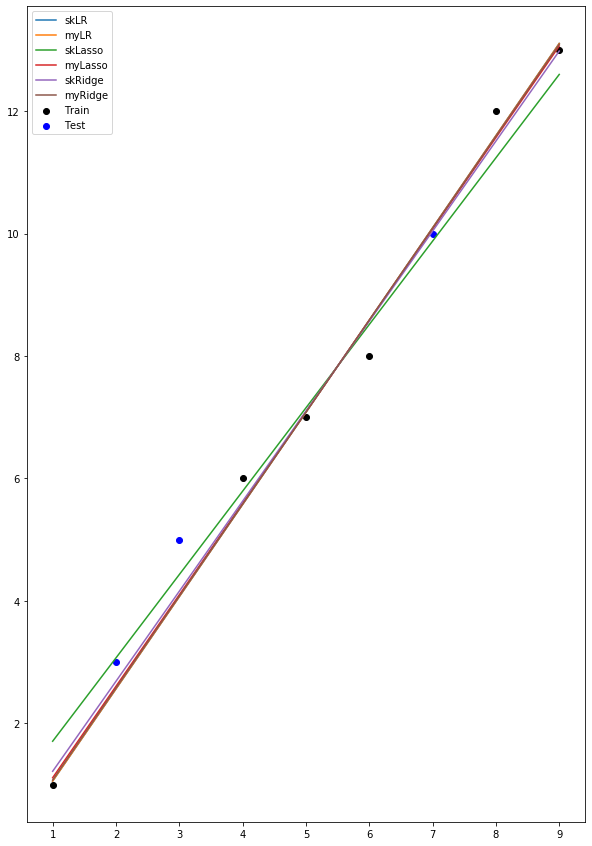

In [56]:
from sklearn import linear_model
X = np.array([1,2,3,4,5,6,7,8,9]).reshape(-1, 1)
y = np.array([1,3,5,6,7,8,10,12,13])
models = {
    'skLR': linear_model.LinearRegression,
    'myLR': LinearRegression,
    'skLasso': linear_model.Lasso,
    'myLasso': Lasso,
    'skRidge': linear_model.Ridge,
    'myRidge': Ridge
}
plot_pipe(X, y, models, feature=2, fit_intercept=True, penalty=1)

## Multi Linear Regression

In [ ]:
from sklearn import datasets, linear_model
X, y = datasets.load_diabetes(return_X_y=True)


In [1]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

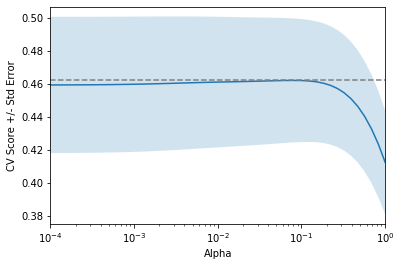

In [5]:
# Import necessary modules
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X_train, y_train, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)


In [ ]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()